# LoL Game Outcome Predictor
based on first 15 minutes of gameplay

#### Things to consider:
1. winrates for each champ are the most recent winrates as of Sept 20, 2019 - this means game patches/updates that affect each champ are not considered
2. there are also winrates for each player, for each champ - these winrates could also be a better feature to use for predicting outcome
3. taking the point in time when an objective was taken into consideration would probably improve this model
4. rank of each player on each team may have an effect on outcome as well
5. taking the point in time of gold differential into account may also improve model
6. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import re

In [2]:
# https://www.leagueofgraphs.com/champions/counters/master

#### Loading all the data files

In [2]:
LOL = pd.read_csv('LeagueofLegends.csv')
matches = pd.read_csv('matchinfo.csv')
kills = pd.read_csv('kills.csv')
gold = pd.read_csv('gold.csv')
column_desc = pd.read_csv('_columns.csv')
monsters = pd.read_csv('monsters.csv')
structures = pd.read_csv('structures.csv')
bans = pd.read_csv('bans.csv')

In [3]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 50)

In [4]:
champs = [name for name in LOL.columns if 'Champ' in name]

In [5]:
list_of_dfs = [LOL, matches, kills, gold, monsters, structures, bans]

In [7]:
matches.head()

League  Year  Season    Type blueTeamTag  bResult  rResult redTeamTag  \
0  NALCS  2015  Spring  Season         TSM        1        0         C9   
1  NALCS  2015  Spring  Season         CST        0        1        DIG   
2  NALCS  2015  Spring  Season         WFX        1        0         GV   
3  NALCS  2015  Spring  Season         TIP        0        1         TL   
4  NALCS  2015  Spring  Season         CLG        1        0         T8   

   gamelength  blueTop blueTopChamp  blueJungle blueJungleChamp   blueMiddle  \
0          40    Dyrus       Irelia    Santorin          RekSai     Bjergsen   
1          38     Cris         Gnar     Impaler          Rengar        Jesiz   
2          40  Flaresz     Renekton  ShorterACE          Rengar     Pobelter   
3          41     Rhux       Irelia        Rush        JarvanIV  XiaoWeiXiao   
4          35    Benny         Gnar     Xmithie        JarvanIV         Link   

  blueMiddleChamp     blueADC blueADCChamp blueSupport blueSupportChamp  \
0            Ahri  WildTurtle         Jinx     Lustboy            Janna   
1            Ahri        Mash      Caitlyn       Sheep            Leona   
2            Fizz       Altec        Sivir       Gleeb            Annie   
3         Leblanc      Apollo        Sivir      Adrian           Thresh   
4       Lissandra  Doublelift     Tristana    aphromoo            Janna   

        redTop redTopChamp     redJungle redJungleChamp redMiddle  \
0        Balls        Gnar        Meteos          Elise       Hai   
1        Gamsu      Irelia       Crumbzz       JarvanIV  Shiphtur   
2     Hauntzer        Sion  Saintvicious         LeeSin     Keane   
3         Quas        Gnar    IWDominate           Nunu     Fenix   
4  CaliTrlolz8        Sion     Porpoise8         RekSai  Slooshi8   

  redMiddleChamp        redADC redADCChamp   redSupport redSupportChamp  \
0           Fizz        Sneaky       Sivir  LemonNation          Thresh   
1           Azir        CoreJJ       Corki      KiWiKiD           Annie   
2           Azir           Cop       Corki   BunnyFuFuu           Janna   
3           Lulu         KEITH      KogMaw      Xpecial           Janna   
4           Lulu  Maplestreet8       Corki        Dodo8           Annie   

                                             Address  
0  http://matchhistory.na.leagueoflegends.com/en/...  
1  http://matchhistory.na.leagueoflegends.com/en/...  
2  http://matchhistory.na.leagueoflegends.com/en/...  
3  http://matchhistory.na.leagueoflegends.com/en/...  
4  http://matchhistory.na.leagueoflegends.com/en/...

In [8]:
kills.head()

Address    Team    Time  \
0  http://matchhistory.na.leagueoflegends.com/en/...  bKills  10.820   
1  http://matchhistory.na.leagueoflegends.com/en/...  bKills  16.286   
2  http://matchhistory.na.leagueoflegends.com/en/...  bKills  18.733   
3  http://matchhistory.na.leagueoflegends.com/en/...  bKills  18.880   
4  http://matchhistory.na.leagueoflegends.com/en/...  bKills  27.005   

           Victim          Killer      Assist_1        Assist_2  \
0          C9 Hai    TSM Bjergsen           NaN             NaN   
1  C9 LemonNation  TSM WildTurtle  TSM Santorin    TSM Bjergsen   
2          C9 Hai    TSM Bjergsen  TSM Santorin  TSM WildTurtle   
3       C9 Meteos       TSM Dyrus  TSM Santorin    TSM Bjergsen   
4        C9 Balls    TSM Bjergsen     TSM Dyrus    TSM Santorin   

         Assist_3     Assist_4  x_pos y_pos  
0             NaN          NaN   9229  8469  
1     TSM Lustboy          NaN  13908  5960  
2     TSM Lustboy          NaN   8281  7889  
3  TSM WildTurtle  TSM Lustboy   8522  8895  
4  TSM WildTurtle  TSM Lustboy   8902  7643

In [9]:
gold.head()

Address      Type  min_1  min_2  \
0  http://matchhistory.na.leagueoflegends.com/en/...  golddiff      0      0   
1  http://matchhistory.na.leagueoflegends.com/en/...  golddiff      0      0   
2  http://matchhistory.na.leagueoflegends.com/en/...  golddiff      0      0   
3  http://matchhistory.na.leagueoflegends.com/en/...  golddiff      0      0   
4  http://matchhistory.na.leagueoflegends.com/en/...  golddiff     40     40   

   min_3  min_4  min_5  min_6  min_7  min_8  min_9  min_10  min_11  min_12  \
0    -14    -65   -268   -431   -488   -789   -494    -625   -1044    -313   
1    -26    -18    147    237   -152     18     88    -242     102     117   
2     10    -60     34     37    589   1064   1258     913    1233    1597   
3    -15     25    228     -6   -243    175   -346      16    -258     -57   
4     44    -36    113    158   -121   -191     23     205     156     272   

   min_13  min_14  min_15  min_16  min_17  min_18  min_19  min_20  min_21  \
0    -760    -697    -790    -611     240   845.0   797.0  1422.0   987.0   
1     802    1420    1394    1301    1489  1563.0  1368.0  1105.0   205.0   
2    1575    3046    2922    3074    3626  3466.0  5634.0  5293.0  4597.0   
3    -190    -111    -335      -8     324   428.0  -124.0   768.0  2712.0   
4    -271    -896    -574     177    -425  -730.0  -318.0   478.0   926.0   

   min_22  min_23  min_24  min_25  min_26  min_27  min_28  min_29  min_30  \
0   169.0   432.0   491.0  1205.0  1527.0  1647.0  1847.0  3750.0  4719.0   
1   192.0   587.0   377.0   667.0   415.0  1876.0  1244.0  2130.0  2431.0   
2  4360.0  4616.0  4489.0  4880.0  5865.0  6993.0  7049.0  7029.0  7047.0   
3  1813.0   198.0  1242.0  1245.0  1278.0  1240.0  -664.0 -1195.0 -1157.0   
4   761.0  -286.0   473.0   490.0  1265.0  2526.0  3890.0  4319.0  5121.0   

   min_31  min_32  min_33  min_34   min_35  min_36   min_37   min_38   min_39  \
0  3561.0  3367.0  2886.0  2906.0   4411.0  4473.0   4639.0   4762.0   4686.0   
1   680.0  1520.0   949.0  1894.0   2644.0  3394.0   3726.0   1165.0      NaN   
2  7160.0  7081.0  7582.0  9917.0  10337.0  9823.0  12307.0  13201.0  13924.0   
3 -2161.0 -2504.0 -3873.0 -3688.0  -3801.0 -3668.0  -3612.0  -5071.0  -2825.0   
4  5140.0  5141.0  6866.0  9517.0  11322.0     NaN      NaN      NaN      NaN   

    min_40  min_41  min_42  min_43  min_44  min_45  min_46  min_47  min_48  \
0   6057.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2  13915.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3  -1464.0 -4507.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   min_49  min_50  min_51  min_52  min_53  min_54  min_55  min_56  min_57  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   min_58  min_59  min_60  min_61  min_62  min_63  min_64  min_65  min_66  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   min_67  min_68  min_69  min_70  min_71  min_72  min_73  min_74  min_75  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN     NaN     NaN     Na

In [10]:
monsters.head()

Address      Team    Time    Type
0  http://matchhistory.na.leagueoflegends.com/en/...  bDragons  37.267  DRAGON
1  http://matchhistory.na.leagueoflegends.com/en/...  bDragons  32.545  DRAGON
2  http://matchhistory.na.leagueoflegends.com/en/...  bDragons  26.177  DRAGON
3  http://matchhistory.na.leagueoflegends.com/en/...  bDragons  19.119  DRAGON
4  http://matchhistory.na.leagueoflegends.com/en/...  bDragons  24.577  DRAGON

In [11]:
structures.head()

Address     Team    Time  \
0  http://matchhistory.na.leagueoflegends.com/en/...  bTowers  27.542   
1  http://matchhistory.na.leagueoflegends.com/en/...  bTowers  39.269   
2  http://matchhistory.na.leagueoflegends.com/en/...  bTowers  33.583   
3  http://matchhistory.na.leagueoflegends.com/en/...  bTowers  23.038   
4  http://matchhistory.na.leagueoflegends.com/en/...  bTowers  16.556   

       Lane          Type  
0  MID_LANE   BASE_TURRET  
1  MID_LANE  NEXUS_TURRET  
2  BOT_LANE  INNER_TURRET  
3  TOP_LANE  INNER_TURRET  
4  BOT_LANE  OUTER_TURRET

#### Check out which team wins more

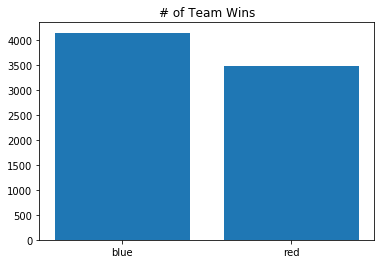

In [12]:
plt.bar(x=['blue','red'], height=[LOL.bResult.sum(),LOL.rResult.sum()])
plt.title('# of Team Wins')
plt.show()

#### LOL dataframe has all lists in string format, so changing them all to lists

In [6]:
# only run once
LOL.golddiff = [literal_eval(array) for array in LOL.golddiff]
LOL.bKills = [literal_eval(array) for array in LOL.bKills]

#### Seeing picks for a certain season (Spring 2015)

In [14]:
spr2015 = LOL.query('Year == 2015')[LOL.Season == 'Spring']

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


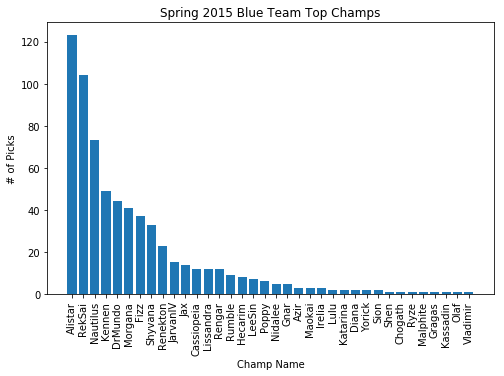

In [15]:
# all champs picked for top lane by blue team for Spring 2015
plt.figure(figsize=(8,5))
plt.title('Spring 2015 Blue Team Top Champs')
plt.xlabel('Champ Name')
plt.ylabel('# of Picks')
plt.xticks(rotation='vertical')
plt.bar(list(set(spr2015.blueTopChamp)),spr2015.blueTopChamp.value_counts())
plt.show()

In [16]:
# winrates are current winrates for each champ, so this will be inaccurate for past games
winrates = pd.read_csv('winrates.csv')

In [17]:
winrates = winrates.sort_values(by='Winrate')

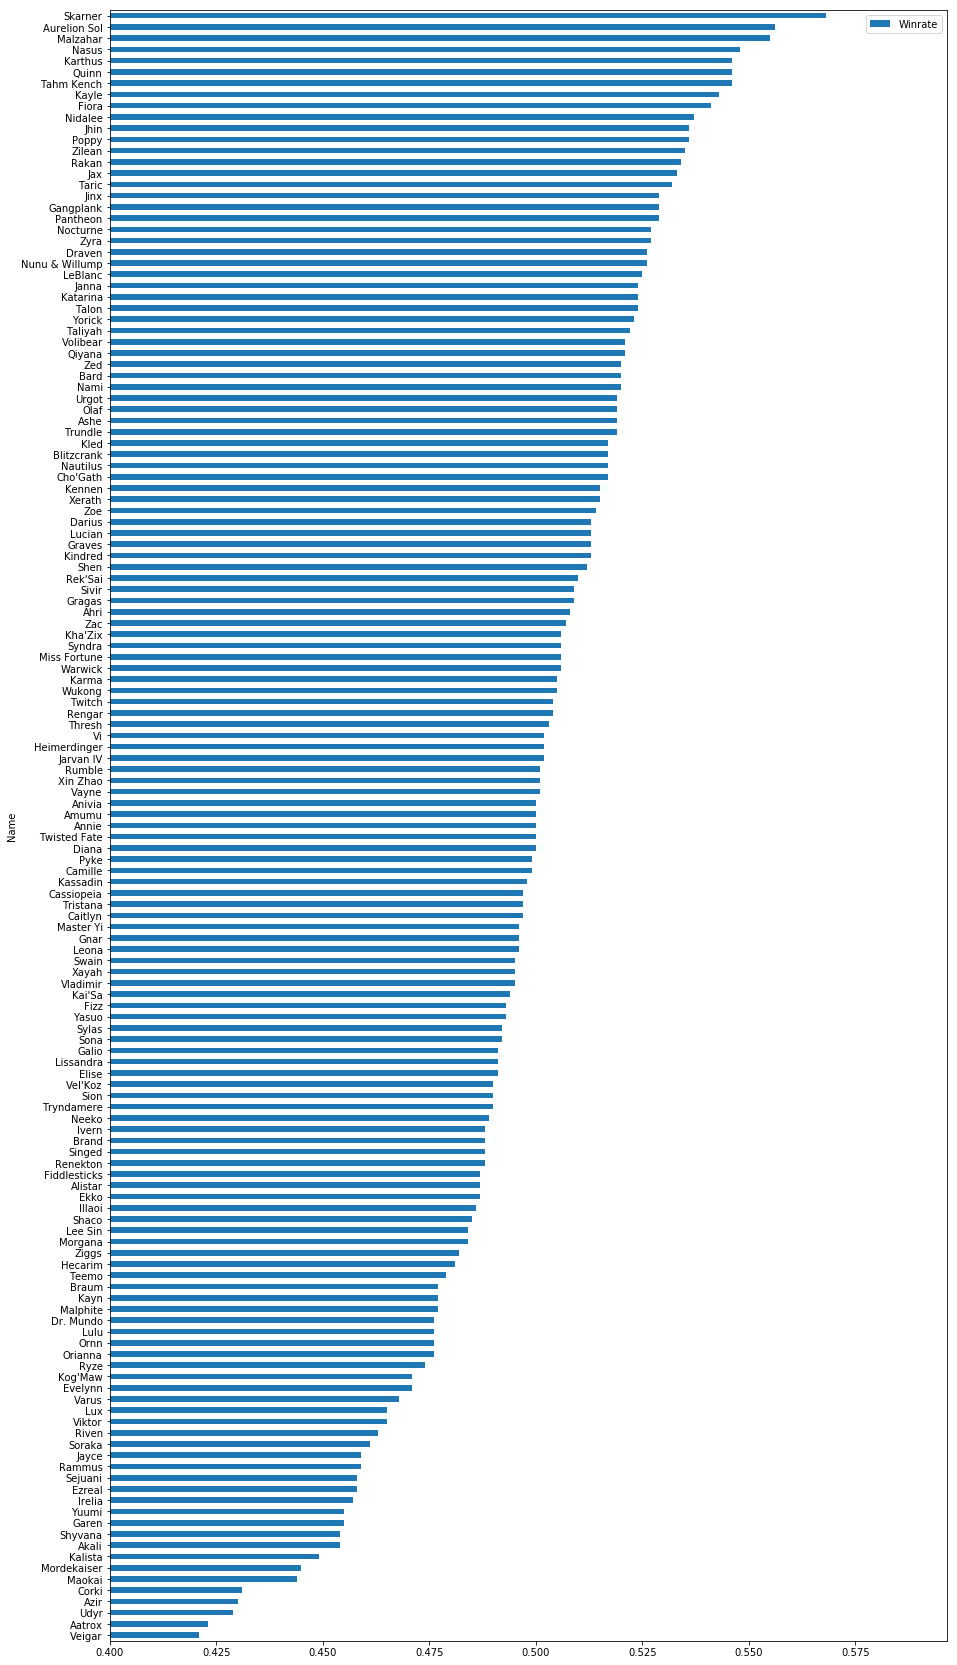

In [18]:
winrates.plot.barh(x='Name',y='Winrate', figsize=(15,30), xlim=(.4))

In [8]:
def create_gameID(df):
    ids = []
    try:
        for i in range(len(df.Address)):
            if '=' not in df.Address[i]:
                ids.append(df.Address[i][df.Address[i].index('JP1')+3:-1])
            else:
                ids.append(df.Address[i][df.Address[i].index('Hash=')+5:-1])
        df['gameID'] = ids
    except:
        None
    return df

In [9]:
for df in list_of_dfs:
    create_gameID(df)

In [10]:
for df in list_of_dfs:
    df = df.drop('Address', axis=1, inplace=True)

### Start creating a final db
Make other table data usable and merge to matches df

#### Make kills data easier to use (no time-series)

In [22]:
column_desc.ColumnDescription[12]

" List of Blue Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos] \n"

In [11]:
bkills = kills[kills.Team == 'bKills'][kills.Time <= 15]
countbkills = bkills.fillna(0).groupby('gameID').count()

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [12]:
rkills = kills[kills.Team == 'rKills'][kills.Time <= 15]
countrkills = rkills.fillna(0).groupby('gameID').count()

/Users/paulyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [13]:
countbkills['totassists'] = countbkills.Assist_1 + countbkills.Assist_2 + countbkills.Assist_3 + countbkills.Assist_4
countrkills['totassists'] = countrkills.Assist_1 + countrkills.Assist_2 + countrkills.Assist_3 + countrkills.Assist_4


add these to a final df

In [14]:
final = matches.merge(bkills.groupby('gameID')[['Killer']].count(), on='gameID', how='left').rename(columns={'Killer':'bkills'})

In [15]:
final = final.merge(countbkills[['totassists']], on='gameID').rename(columns={'totassists':'b_assists'})

In [16]:
final = final.merge(countrkills[['Killer']], on='gameID').rename(columns={'Killer':'rkills'})

In [17]:
final = final.merge(countrkills[['totassists']], on='gameID').rename(columns={'totassists':'r_assists'})

#### Make monsters data easier to use

In [30]:
set(monsters.Team)

{'bBarons', 'bDragons', 'bHeralds', 'rBarons', 'rDragons', 'rHeralds'}

In [31]:
set(monsters.Type)

{'AIR_DRAGON',
 'BARON_NASHOR',
 'DRAGON',
 'EARTH_DRAGON',
 'ELDER_DRAGON',
 'FIRE_DRAGON',
 'RIFT_HERALD',
 'WATER_DRAGON'}

In [18]:
monsters = monsters[monsters.Time <=15]

In [19]:
bdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bDragons', level='Team').rename(columns={'Type':'bdragons'})
# bbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bBarons', level='Team').rename(columns={'Type':'bbarons'})
bhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('bHeralds', level='Team').rename(columns={'Type':'bheralds'})


In [20]:
rdrags = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rDragons', level='Team').rename(columns={'Type':'rdragons'})
# rbars = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rBarons', level='Team').rename(columns={'Type':'rbarons'})
rhers = monsters.groupby(['gameID','Team']).count()[['Type']].xs('rHeralds', level='Team').rename(columns={'Type':'rheralds'})


add to final df

In [21]:
final = final.merge(bdrags, on='gameID',how='left').merge(bhers, on='gameID',how='left')
final = final.merge(rdrags, on='gameID',how='left').merge(rhers, on='gameID',how='left')

In [22]:
final = final.fillna(0)

#### Make gold data easier to use
Domain knowledge: gold differential is very important in any matchup <br>
Gold amounts for each position is very player specific, and may not really be good features to include

In [37]:
column_desc.ColumnDescription[10]

' Gold difference - computed Blue minus Red - by minute \n'

In [23]:
gold15min = gold[gold.Type == 'golddiff'][['gameID','min_15']].groupby('gameID').sum()

In [24]:
gold15min = gold15min.rename(columns={'min_15':'gold_15_min'})

In [25]:
groupedgold = gold[gold['Type'] == 'golddiff'].groupby('gameID').sum()

In [26]:
groupedgold['avggolddiff'] = groupedgold.mean(axis=1)

In [27]:
# half-time gold and end-time gold

add to final df

In [28]:
final = final.merge(gold15min, on='gameID', how='left')

#### Make structures data easier to use

In [44]:
set(structures.Team)

{'bInhibs', 'bTowers', 'rInhibs', 'rTowers'}

In [29]:
# group structures and filter out anything that was taken AFTER 15-minute benchmark
grp_struct = structures[structures.Time <= 15].groupby(['gameID','Team','Lane']).count()[['Type']]

In [30]:
bot_structs = grp_struct.unstack().unstack()['Type']['BOT_LANE']

bot_structs.columns = [col + '_bot' for col in bot_structs.columns]

bot_structs = bot_structs.fillna(0)

bot_structs = bot_structs.reset_index()

In [31]:
mid_structs = grp_struct.unstack().unstack()['Type']['MID_LANE']

mid_structs.columns = [col + '_mid' for col in mid_structs.columns]

mid_structs = mid_structs.fillna(0)

mid_structs = mid_structs.reset_index()

In [32]:
top_structs = grp_struct.unstack().unstack()['Type']['TOP_LANE']

top_structs.columns = [col + '_top' for col in top_structs.columns]

top_structs = top_structs.fillna(0)

top_structs = top_structs.reset_index()

In [33]:
final = final.merge(top_structs, on='gameID', how='left').merge(mid_structs, on='gameID', how='left').merge(bot_structs, on='gameID', how='left')

#### Make winrates easier to use
Instead of using winrates file, calculated my own winrates using the data in dataset

In [50]:
dict(zip(winrates.Name, winrates.Winrate))

{'Veigar': 0.42100000000000004,
 'Aatrox': 0.423,
 'Udyr': 0.429,
 'Azir': 0.43,
 'Corki': 0.431,
 'Maokai': 0.444,
 'Mordekaiser': 0.445,
 'Kalista': 0.449,
 'Akali': 0.45399999999999996,
 'Shyvana': 0.45399999999999996,
 'Garen': 0.455,
 'Yuumi': 0.455,
 'Irelia': 0.457,
 'Ezreal': 0.45799999999999996,
 'Sejuani': 0.45799999999999996,
 'Rammus': 0.45899999999999996,
 'Jayce': 0.45899999999999996,
 'Soraka': 0.461,
 'Riven': 0.46299999999999997,
 'Viktor': 0.465,
 'Lux': 0.465,
 'Varus': 0.46799999999999997,
 'Evelynn': 0.47100000000000003,
 "Kog'Maw": 0.47100000000000003,
 'Ryze': 0.474,
 'Orianna': 0.47600000000000003,
 'Ornn': 0.47600000000000003,
 'Lulu': 0.47600000000000003,
 'Dr. Mundo': 0.47600000000000003,
 'Malphite': 0.47700000000000004,
 'Kayn': 0.47700000000000004,
 'Braum': 0.47700000000000004,
 'Teemo': 0.479,
 'Hecarim': 0.48100000000000004,
 'Ziggs': 0.48200000000000004,
 'Morgana': 0.484,
 'Lee Sin': 0.484,
 'Shaco': 0.485,
 'Illaoi': 0.486,
 'Ekko': 0.487000000000000

In [51]:
bTopWR = matches[['blueTopChamp','bResult']].groupby('blueTopChamp').sum()
bTopWR['topwinrate'] = bTopWR.bResult/sum(bTopWR.bResult)

In [52]:
bJGWR = matches[['blueJungleChamp','bResult']].groupby('blueJungleChamp').sum()
bJGWR['jgwinrate'] = bJGWR.bResult/sum(bJGWR.bResult)

In [53]:
bMidWR = matches[['blueMiddleChamp','bResult']].groupby('blueMiddleChamp').sum()
bMidWR['midwinrate'] = bMidWR.bResult/sum(bMidWR.bResult)

In [54]:
bADCWR = matches[['blueADCChamp','bResult']].groupby('blueADCChamp').sum()
bADCWR['adcwinrate'] = bADCWR.bResult/sum(bADCWR.bResult)

In [55]:
bSupWR = matches[['blueSupportChamp','bResult']].groupby('blueSupportChamp').sum()
bSupWR['supwinrate'] = bSupWR.bResult/sum(bSupWR.bResult)

In [56]:
WR = bTopWR.merge(bJGWR, how='outer', left_index=True, right_index=True, suffixes=('_top','_jg'))

WR = WR.merge(bMidWR, how='outer', left_index=True, right_index=True)

WR = WR.merge(bADCWR, how='outer', left_index=True, right_index=True, suffixes=('_mid','_adc'))

WR = WR.merge(bSupWR, how='outer', left_index=True, right_index=True).rename(columns={'bResult':'bResult_sup'})

WR = WR.fillna(0)

In [57]:
WR['totwins'] = WR.bResult_top + WR.bResult_jg + WR.bResult_mid + WR.bResult_adc + WR.bResult_sup

WR['avgwinrate'] = WR.totwins/sum(WR.totwins)

In [58]:
WR = WR.drop(['bResult_top','bResult_jg','bResult_mid','bResult_adc','bResult_sup','topwinrate', 'jgwinrate','midwinrate','adcwinrate','supwinrate'],axis=1)

#### Make each champ a dummy variable

In [34]:
all_champs = []
for col in champs:
    all_champs.extend(list(matches[f'{col}'].unique()))

In [35]:
dummies = []

for idx, row in matches[champs].iterrows():
    new = {}
    for champ in all_champs:
        new[champ] = 0
    for played in row:
        if played in all_champs:
            new[played] += 1
        else:
            continue
    dummies.append(new)

In [36]:
champsdf = pd.DataFrame(dummies)

In [37]:
champsdf.rename(columns={'MonkeyKing':'Wukong'},inplace=True)

add to final df

In [38]:
final = pd.concat([final,champsdf], axis=1)

# Remove some features

In [39]:
cols_to_drop = list(final.columns[:29])

In [40]:
cols_to_drop.remove('bResult')

In [41]:
final = final.drop(cols_to_drop, axis=1)

In [42]:
final.fillna(0,inplace=True)

### More EDA for further feature selection

In [43]:
import seaborn as sns

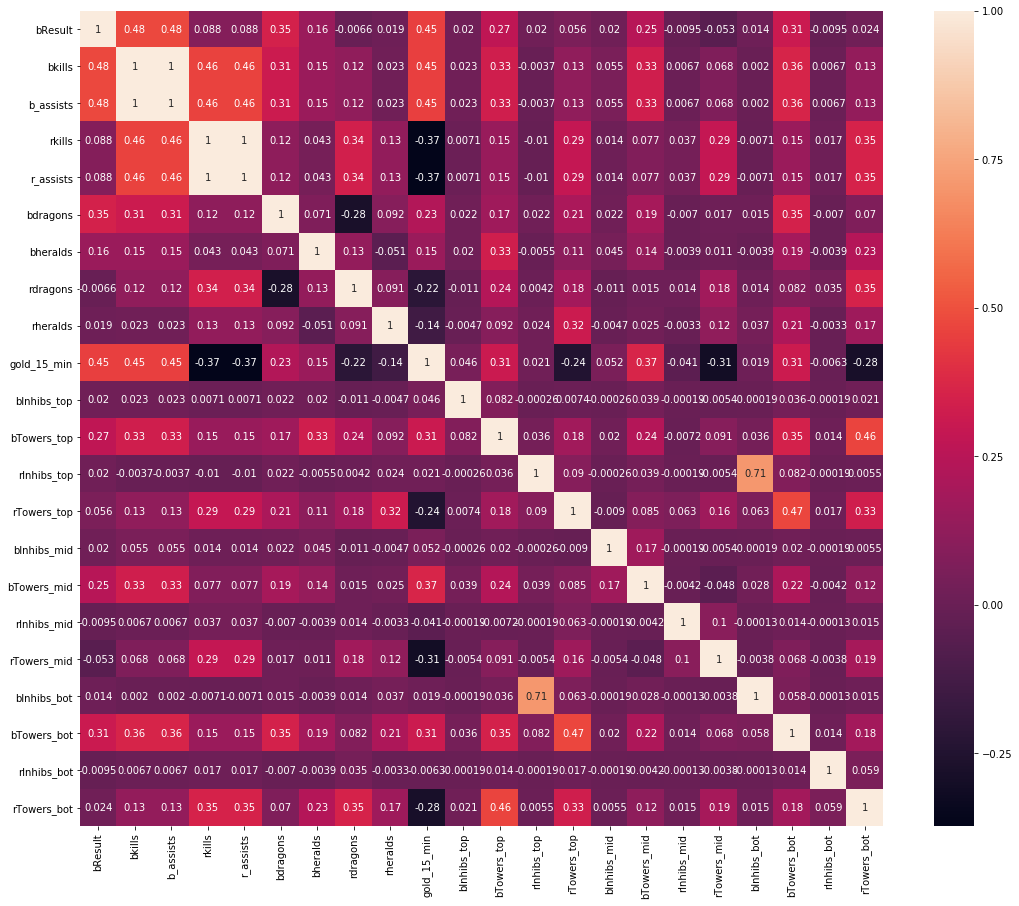

In [44]:
fig1, ax1 = plt.subplots(figsize=(18,15))

sns.heatmap(final[final.columns[:23]].corr(), annot=True)

In [45]:
# getting rid of highly correlated features
final2 = final.drop(['b_assists', 'r_assists'],axis=1)

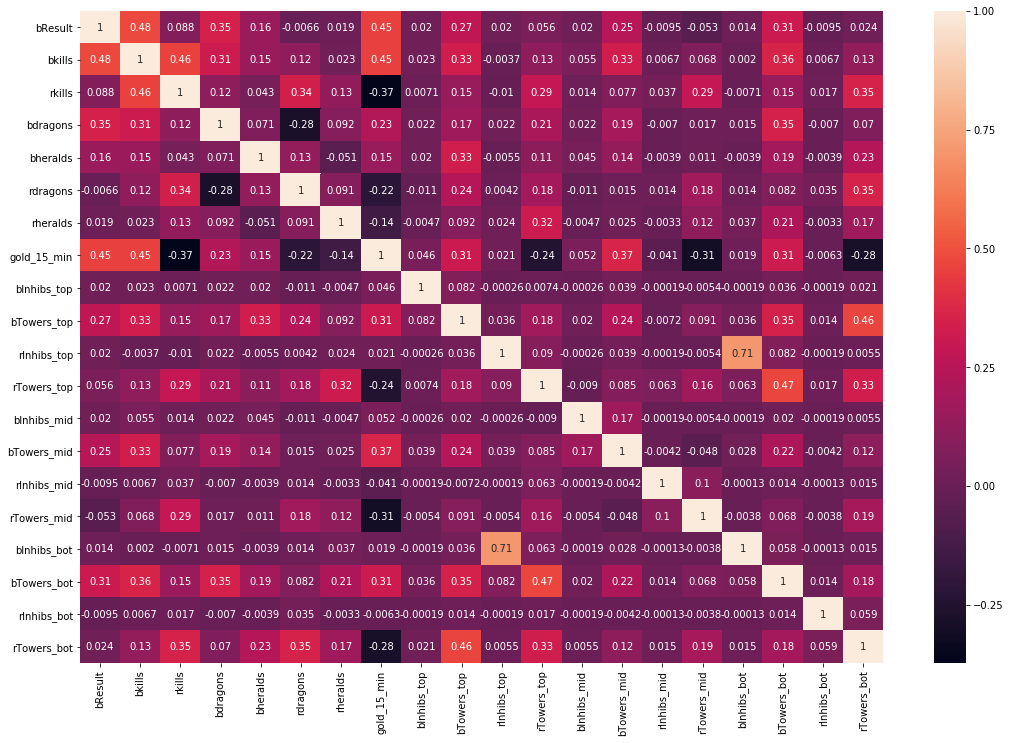

In [46]:
fig1, ax2 = plt.subplots(figsize=(18,12))

sns.heatmap(final2[final2.columns[:21]].corr(),annot=True)

### Setting up for modelling

In [47]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

In [48]:
features = final2.columns[2:]

In [49]:
X = final2.loc[:,features]
y = final2.loc[:,'bResult']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Flaunt what ya mama gave ya
(Modelling)

In [51]:
from sklearn.dummy import DummyClassifier

In [52]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)
dummypred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummypred))

              precision    recall  f1-score   support

         0.0       0.59      0.50      0.54      1367
         1.0       0.39      0.48      0.43       919

   micro avg       0.49      0.49      0.49      2286
   macro avg       0.49      0.49      0.49      2286
weighted avg       0.51      0.49      0.50      2286



### Random Forest
##### First random forest

In [78]:
forest_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,2,5,10,15,20],
    'n_estimators': [1,2,3,4,5,10,15],
    'n_jobs': [-1]
}

In [79]:
grid_search_forest1 = GridSearchCV(RandomForestClassifier(), forest_params, cv=3, scoring='accuracy')
grid_search_forest1.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [80]:
grid_search_forest1.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 15, 'n_jobs': -1}

In [53]:
forest1 = RandomForestClassifier(n_estimators=10, max_depth=10, criterion='gini', n_jobs=-1)

In [54]:
forest1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
forest1.score(X_train, y_train)

0.8509561304836896

In [56]:
forest1_preds = forest1.predict(X_test)

In [57]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=forest1_preds))

0    1
0  1072  295
1   237  682

In [58]:
forest1_ft_imp = pd.DataFrame(dict(zip(list(final2.columns[2:]), list(forest1.feature_importances_))),index=range(1))

# only care about features with importance of .01 or more
forest1_ft_imp = forest1_ft_imp[forest1_ft_imp>=.01].dropna(axis=1).T

forest1_ft_imp.columns = ['Feature_Weight']

In [59]:
forest1_ft_imp.sort_values(by='Feature_Weight', inplace=True)

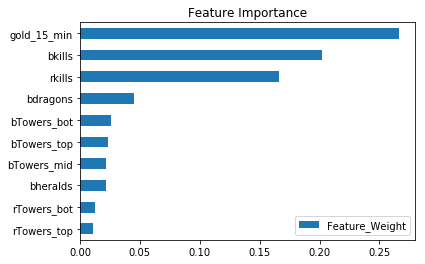

In [60]:
forest1_ft_imp.plot.barh(title='Feature Importance')

### Bagging?

In [89]:
bagging_params = {
    'bootstrap': [True, False],
    'max_features': [1,2,5,10,15,20],
    'n_estimators': [1,2,3,4,5,10,15],
    'n_jobs': [-1],
    'max_samples': [1,2,3,4,5,10,15]
}

In [90]:
grid_search_bagging = GridSearchCV(BaggingClassifier(), bagging_params, cv=3, scoring='accuracy')
grid_search_bagging.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': [True, False], 'max_features': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1], 'max_samples': [1, 2, 3, 4, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [91]:
grid_search_bagging.best_params_

{'bootstrap': True,
 'max_features': 15,
 'max_samples': 15,
 'n_estimators': 5,
 'n_jobs': -1}

In [61]:
baggage1 = BaggingClassifier(bootstrap=True, max_features=15, max_samples=15, n_estimators=10, n_jobs=-1)

In [62]:
baggage1.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=15, max_samples=15,
         n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [63]:
baggage1.score(X_train, y_train)

0.7334083239595051

In [64]:
baggage1_preds = baggage1.predict(X_test)

In [65]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=baggage1_preds))

0    1
0  1074  293
1   372  547

Bagging..... not good

### OMG, I'm so BOOSTED!
(XG Boost)

In [67]:
from xgboost import XGBClassifier
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tpot import TPOTClassifier, TPOTRegressor
from deap.gp import Primitive

In [68]:
clf = XGBClassifier()
booster = clf.fit(np.array(X_train), np.array(y_train))
training_preds = clf.predict(np.array(X_train))
val_preds = clf.predict(np.array(X_test))
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 81.65%
Validation accuracy: 77.69%


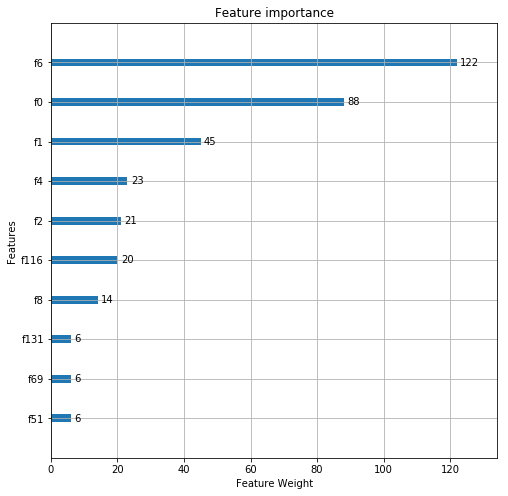

In [69]:
fig, ax = plt.subplots(figsize=(8,8))
n_features = X_train.shape[1]
xgb.plot_importance(clf.fit(np.array(X_train), np.array(y_train)), ax=ax, xlabel='Feature Weight', max_num_features=10)
plt.show()

In [100]:
features[6], features[0], features[1], features[4], features[2], features[116], features[8], features[131], features[69], features[51]

('gold_15_min',
 'bkills',
 'rkills',
 'rdragons',
 'bdragons',
 'Shen',
 'bTowers_top',
 'Thresh',
 'Karthus',
 'Gangplank')

##### Genetic algorithm to find best params for XG Boost

In [101]:
xgparams = {'max_depth': np.arange(1,200,1),
          'learning_rate': np.arange(0.0001,0.1,0.0001),
          'n_estimators': np.arange(1,200,1),
          'nthread':[6],
          'gamma':np.arange(0.00001,0.1,0.00001),
          'subsample':np.arange(0.1,2,0.1),
          'reg_lambda': np.arange(0.1,200,1),
          'reg_alpha': np.arange(1,200,1),
          'min_child_weight': np.arange(1,200,1),
          'gamma': np.arange(0.1,2,0.1),
          'colsample_bytree': np.arange(0.1,2,0.1),
          'colsample_bylevel': np.arange(0.1,2,0.1)
         }

In [102]:
tpot_classifier = TPOTClassifier(generations=10, population_size=500, offspring_size=250,
                                verbosity=2, early_stop=8,
                                config_dict={'xgboost.XGBClassifier': xgparams}, cv = 3, scoring = 'accuracy', n_jobs=-1)
tpot_classifier.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 0.7978973711031639
Generation 2 - Current best internal CV score: 0.7978973711031639
Generation 3 - Current best internal CV score: 0.7978973711031639
Generation 4 - Current best internal CV score: 0.7978973711031639

The optimized pipeline was not improved after evaluating 8 more generations. Will end the optimization process.

TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(CombineDFs(input_matrix, input_matrix), colsample_bylevel=0.5, colsample_bytree=0.2, gamma=1.9000000000000001, learning_rate=0.058100000000000006, max_depth=130, min_child_weight=28, n_estimators=110, nthread=6, reg_alpha=17, reg_lambda=129.1, subsample=1.0)


TPOTClassifier(config_dict={'xgboost.XGBClassifier': {'max_depth': array([  1,   2, ..., 198, 199]), 'learning_rate': array([0.0001, 0.0002, ..., 0.0998, 0.0999]), 'n_estimators': array([  1,   2, ..., 198, 199]), 'nthread': [6], 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
    ... 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])}},
        crossover_rate=0.1, cv=3, disable_update_check=False, early_stop=8,
        generations=10, max_eval_time_mins=5, max_time_mins=None,
        memory=None, mutation_rate=0.9, n_jobs=-1, offspring_size=250,
        periodic_checkpoint_folder=None, population_size=500,
        random_state=None, scoring='accuracy', subsample=1.0,
        template=None, use_dask=False, verbosity=2, warm_start=False)

In [103]:
args = {}
for arg in tpot_classifier._optimized_pipeline:
    if type(arg) != Primitive:
        try:
            if arg.value.split('__')[1].split('=')[0] in ['max_depth', 'n_estimators', 'nthread','min_child_weigh']:
                args[arg.value.split('__')[1].split('=')[0]] = int(arg.value.split('__')[1].split('=')[1])
            else:
                args[arg.value.split('__')[1].split('=')[0]] = float(arg.value.split('__')[1].split('=')[1])
        except:
            pass
xgb_params = args

In [104]:
optimized_xgb = XGBClassifier(**xgb_params)
optimized_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bynode=1, colsample_bytree=0.2, gamma=1.9000000000000001,
       learning_rate=0.058100000000000006, max_delta_step=0, max_depth=130,
       min_child_weight=28.0, missing=None, n_estimators=110, n_jobs=1,
       nthread=6, objective='binary:logistic', random_state=0,
       reg_alpha=17.0, reg_lambda=129.1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1.0, verbosity=1)

In [105]:
optimized_xgb.score(X_train,y_train)

0.7997750281214848

In [106]:
optimized_xgb.score(X_test, y_test)

0.7773403324584427

In [107]:
opt_xgb_pred = optimized_xgb.predict(X_test)

In [108]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=opt_xgb_pred))

0    1
0  1106  261
1   248  671

In [110]:
from sklearn.externals import joblib
# save model
joblib.dump(optimized_xgb, 'optimized_xgb.pkl')
# retrieve saved model (later, if necessary...)
# model = joblib.load('dummy_baseline_model.pkl')

['optimized_xgb.pkl']

### Principal Component Analysis (PCA)

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [77]:
import plotly.express as px
import plotly.graph_objects as go

##### Normalize data for PCA

In [72]:
stdX = StandardScaler().fit_transform(X)
normalized_df = pd.DataFrame(data=stdX, columns=X.columns)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [73]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(stdX)

In [74]:
pcdf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3'])
pcaresults = pd.concat([pcdf, y], axis=1)

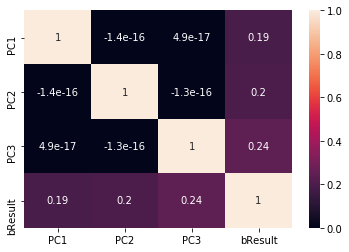

In [75]:
sns.heatmap(pcaresults.corr(),annot=True)

In [78]:
fig2 = px.scatter_3d(pcaresults, x='PC1',y='PC2',z='PC3', color='bResult')

fig2.show()

### Trying models on PCA results

In [79]:
X2 = pcaresults[['PC1', 'PC2', 'PC3']]

In [80]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,random_state=42)

In [81]:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X2_train, y_train)
dummypred = dummy_clf.predict(X2_test)
print(classification_report(y_test, dummypred))

              precision    recall  f1-score   support

         0.0       0.59      0.50      0.54      1367
         1.0       0.40      0.49      0.44       919

   micro avg       0.50      0.50      0.50      2286
   macro avg       0.50      0.50      0.49      2286
weighted avg       0.51      0.50      0.50      2286



In [116]:
pca_grid = GridSearchCV(RandomForestClassifier(),forest_params, cv=3, scoring='accuracy')
pca_grid.fit(X2_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 5, 10, 15, 20], 'n_estimators': [1, 2, 3, 4, 5, 10, 15], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [117]:
pca_grid.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 10, 'n_jobs': -1}

In [82]:
forest_pca = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=10, n_jobs=-1)
forest_pca.fit(X2_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [83]:
forest_pca.score(X2_train, y_train)

0.6812898387701537

In [84]:
forest_pca_pred = forest_pca.predict(X2_test)

In [85]:
print(classification_report(y_test, forest_pca_pred))

              precision    recall  f1-score   support

         0.0       0.69      0.66      0.68      1367
         1.0       0.52      0.55      0.54       919

   micro avg       0.62      0.62      0.62      2286
   macro avg       0.61      0.61      0.61      2286
weighted avg       0.62      0.62      0.62      2286



In [86]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=forest_pca_pred))

0    1
0  906  461
1  410  509

### SVM?

In [145]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline

In [152]:
svm = SVC()

In [153]:
svm.fit(X2_train, y_train)

/Users/paulyun/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [154]:
svm.score(X2_train, y_train)

0.6743532058492688

In [155]:
svm_pred = svm.predict(X2_test)

In [156]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

         0.0       0.79      0.55      0.65      1367
         1.0       0.54      0.78      0.64       919

   micro avg       0.64      0.64      0.64      2286
   macro avg       0.66      0.66      0.64      2286
weighted avg       0.69      0.64      0.64      2286



In [159]:
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=svm_pred))

0    1
0  746  621
1  199  720